In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import cm
from ISLP import confusion_table
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection as skm
from ISLP.svm import plot as plot_svm
from matplotlib.pyplot import subplots
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Introduction 

# Literature Review

# Problem Description:

The task is to predict whether an individual is likely to experience a divorce based on a set of features collected from a the divorce datset.

Approach:

The objective is to implement Bayesian Logistic Regression for this prediction task. This involves creating a model that links the input features in this case Principal Components to the target outcome (whether or not the individual is divorced). We will then sample from the posterior distribution of the model’s parameters. In logistic regression, the parameters to estimate are the coefficients or weights assigned to each feature. The outcome of this process is a distribution of parameter values drawn from the posterior, known as the "trace." We will then plot all of the points and then examine the decision boundary. We will look at the distribution of all test and training data points based on the two PCs. Lastly we will see the contributing factors to divorce risks and top features of the Principal Components

We will be using the PYMC library to create our model. PyMC is an open-source probabilistic programming framework written in Python. It leverages PyTensor to compute gradients through automatic differentiation and can compile probabilistic models dynamically to run on a variety of computational backends, improving performance and speed. 

Gradient-based methods for Markov Chain Monte Carlo (MCMC) sampling, particularly Hamiltonian Monte Carlo (HMC), enable efficient inference for more complex models. However, these methods require the calculation of gradients, which can be challenging in some caseed.

# Data
The dataset used in this analysis was survey data. There were 170 participants of which 84 were divorced and 86 were married. There were 84 males and 86 females. The research data was collected using the face-to-face interview technique and via Google Drive containing 55 questions. The 55th variable is binary, indicating whether the person is married or divorced. The remaining 54 questions have an ordinal output, ranging from 0 to 4 in which 4 represents; “strongly agree”—these 54 questions concern questions related to how the relationship is perceived. The survey was taken in Turkey in 2019 (Yontem et al, 2019). The data is publicly available on; Kaggle Dataset


In [4]:
import os 
import pandas as pd
os.chdir(r"C:\Users\jamak\OneDrive\Lund\Machine Learning")

# Loading data
data = pd.read_csv("divorce.csv")
X = data.drop(columns= ['Divorce_Y_N'])
y = data['Divorce_Y_N']

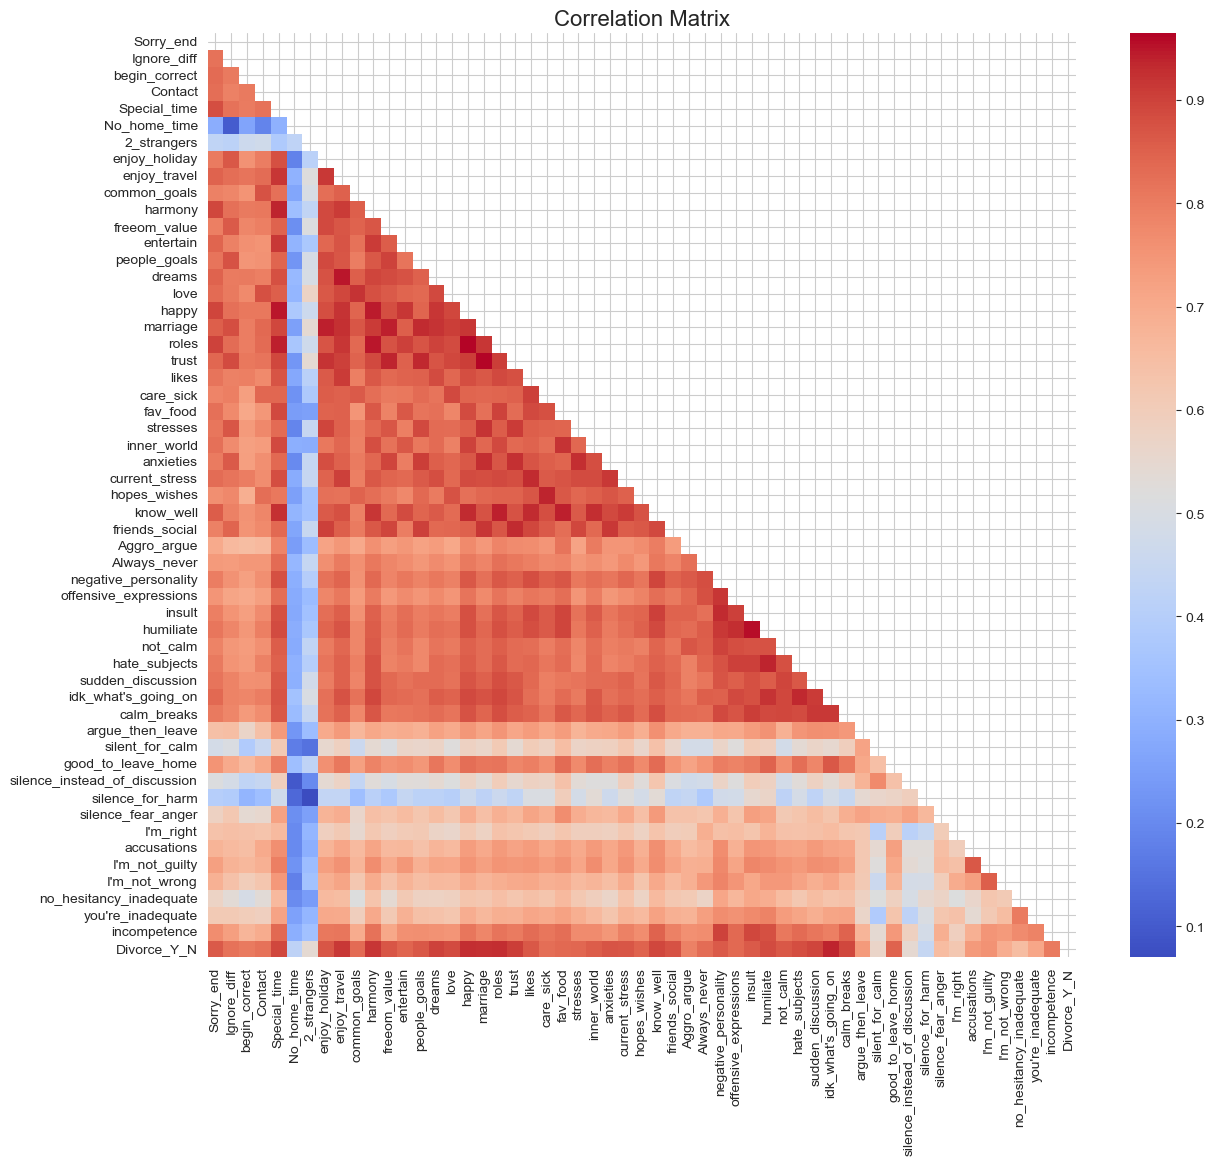

Number of low correlated variables: 14
Number of highly correlated variables: 41
Weakest corraleted variable: No_home_time with value: 0.2629620065293393
Weakest Two Correlations:
No_home_time    0.262962
2_strangers     0.395847
dtype: float64


In [67]:
# Computing correlation matrix 
correlation_matrix = data.corr()

# Mask the upper triangle of the heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix', fontsize=16)
plt.savefig('corr_visual', dpi=300, bbox_inches='tight')
plt.show()

# Compute the mean correlation for each variable, excluding self-correlations (diagonal values)
mean_correlations = correlation_matrix.apply(lambda x: (x.sum() - x[x.name]) / (len(x) - 1))

# Display variables with mean correlations less than 0.7
low_corr_var = mean_correlations[mean_correlations < 0.7]

# Display variables with mean correlations greater than 0.7
high_corr_var = mean_correlations[mean_correlations > 0.7]

print(f"Number of low correlated variables: {low_corr_var.count()}")
print(f"Number of highly correlated variables: {high_corr_var.count()}")
print(f"Weakest corraleted variable: {mean_correlations.idxmin()} with value: {mean_correlations.min()}")

# Find the two weakest correlations in the correlation matrix
weakest_two = mean_correlations.sort_values(key=abs).drop_duplicates().iloc[:2]

# Display the weakest two correlations
print("Weakest Two Correlations:")
print(weakest_two)

As can be seen on the correlation tests most variables show strong correlations indicated by the red coloring on the heeatmap. Notably, two variables—"stranger time" and "no home time"—exhibit weaker correlations, represented by lighter blue shades. Upon quantifying the correlations, we identified 41 variables with averagecorrelations exceeding 0.7 and 11 variables below this threshold. The weakest average correlation, at 0.26, corresponds to "no home time". These findings confirm our expectations, demonstrating that the dataset is predominantly characterized by strong inter-variable correlations.

These strong intervariable correlations may pose challenges to our Bayesian logistic regression model. When predictors are highly correlated, their effects on the target overlap, making it difficult to separate their individual contributions.

## Using PCA to Address Strong Inter-Variable Correlations


Optimal number of PCs: 2


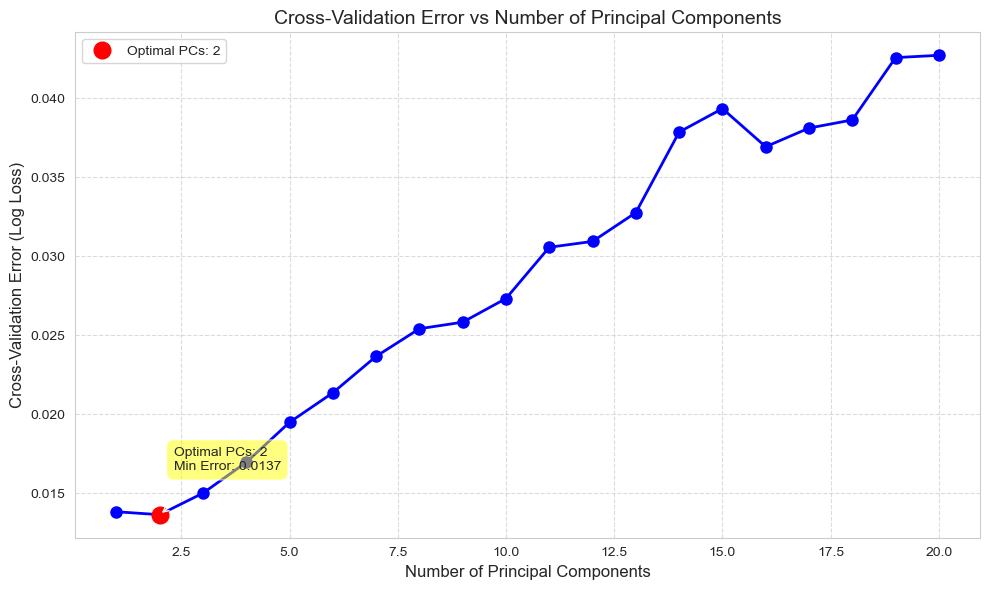

Optimal number of PCs: 2
Minimum cross-validation error: 0.0137


NameError: name 'pca' is not defined

In [9]:
def find_optimal_pcs(X, y, max_pcs=20):
    """
    Finds the optimal number of principal components using cross-validation.

    Parameters:
    - X: Features 
    - y: Target 
    - max_pcs: Maximum number of PCs to test

    Returns:
    - Optimal number of PCs
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    errors = []
    
    for n_pcs in range(1, max_pcs + 1):
        pca = PCA(n_components=n_pcs)
        X_pca = pca.fit_transform(X)
        model = LogisticRegression(solver='lbfgs', max_iter=1000)
        cv_error = -cross_val_score(model, X_pca, y, cv=kf, scoring='neg_log_loss').mean()
        errors.append(cv_error)
    
    optimal_pcs = np.argmin(errors) + 1  # Index to n_components
    return optimal_pcs, errors

# Find optimal PCs for your dataset
X = data.drop(columns= ['Divorce_Y_N'])
y = data['Divorce_Y_N']

optimal_pcs, errors = find_optimal_pcs(X, y, max_pcs=min(X.shape[1], 20))
print(f"Optimal number of PCs: {optimal_pcs}")

def plot_cv_errors(X, y, max_pcs=20):
    """
    Plots cross-validation errors for different numbers of principal components.
    
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    errors = []
    
    # Calculate errors for different numbers of PCs
    for n_pcs in range(1, max_pcs + 1):
        pca = PCA(n_components=n_pcs)
        X_pca = pca.fit_transform(X)
        model = LogisticRegression(solver='lbfgs', max_iter=1000)
        cv_error = -cross_val_score(model, X_pca, y, cv=kf, scoring='neg_log_loss').mean()
        errors.append(cv_error)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Plot the error curve
    plt.plot(range(1, max_pcs + 1), errors, 'bo-', linewidth=2, markersize=8)
    
    # Add labels and title
    plt.xlabel('Number of Principal Components', fontsize=12)
    plt.ylabel('Cross-Validation Error (Log Loss)', fontsize=12)
    plt.title('Cross-Validation Error vs Number of Principal Components', fontsize=14)
    
    # Highlight the optimal number of PCs
    optimal_pcs = np.argmin(errors) + 1
    plt.plot(optimal_pcs, min(errors), 'ro', markersize=12, label=f'Optimal PCs: {optimal_pcs}')
    
    # Add a text box with the optimal value
    plt.annotate(f'Optimal PCs: {optimal_pcs}\nMin Error: {min(errors):.4f}',
                xy=(optimal_pcs, min(errors)),
                xytext=(10, 30),
                textcoords='offset points',
                ha='left',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
   
    plt.grid(True, linestyle='--', alpha=0.7)
    
    
    plt.legend()
    
    
    plt.tight_layout()
    return plt.gcf()

# Use the function with your data
max_pcs = min(X.shape[1], 20)
fig = plot_cv_errors(X, y, max_pcs)
plt.show()

# Print the optimal number of PCs and its corresponding error
optimal_pcs = np.argmin(errors) + 1
print(f"Optimal number of PCs: {optimal_pcs}")
print(f"Minimum cross-validation error: {min(errors):.4f}")


explained_variance_ratio = pca.explained_variance_ratio_[:2]
print("\nExplained Variance Ratio:")
print(f"PC1: {explained_variance_ratio[0]:.3f}")
print(f"PC2: {explained_variance_ratio[1]:.3f}")
print(f"Total: {sum(explained_variance_ratio):.3f}")
pca = PCA(n_components=optimal_pcs)
X_pca = pca.fit_transform(X)


# Principal Component Optimization Results

The graph illustrates the relationship between the number of principal components (PCs) and the cross-validation error (log loss) in our divorce prediction model running a logistic regression model. Bayesian logistic regression is computationally intensive due to the sampling process (MCMC) thus running it repeatedly to select the optimal number of PCs can be time-consuming. Using a normal logistic regression is much faster and allows us to test multiple numbers of PCs efficiently.This visualization helps in determining the optimal dimensionality reduction for our dataset.

Key Findings:

We can see from the results that the optimal number of PCs is 2 with a cross-validation error of 0.0137 (log loss) which is the lowest value out of all the PCs. The first principal component captures about 77.2% of the total variability in the dataset, highlighting its dominance in explaining the data's structure. The second principal component adds only 3.67% to the explained variability, indicating that most of the information is concentrated in the first component. This is expected as the first principal component always explains the greatest variance. Selecting the PC that explains the most amount of variance in this case up to 0.807 and also has the lowest error in cross-validation means that the optimal number of components is determined to be two. This reduction simplifies the data significantly while retaining the majority of the essential information as it provides the maximum amount of dimension reductionality while also making the model more interpretable and efficient for further analysis.

- Optimal Number of PCs: 2
- Minimum Error Rate: 0.0137 (log loss)
- The error rate reaches its minimum at 2 PCs
- This suggests that additional components beyond 2 begin introducing noise rather than useful information


In [11]:
# Apply PCA with the optimal number of components
pca = PCA(n_components=optimal_pcs)
X_pca = pca.fit_transform(X)

# Combine PCs with the target variable
data1 = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(optimal_pcs)])
data1['target'] = y


# Bayesian Logistic Regression: A Probabilistic Approach to Divorce Prediction

In this analysis, we implemented a Bayesian Logistic Regression model to predict divorce outcomes using principal components derived from relationship questionnaire data. Unlike traditional logistic regression, which provides point estimates, the Bayesian approach offers a complete probabilistic framework that captures uncertainty in our predictions and parameter estimates.

Our model has a binary response variable indicating whether an individual is divorced or not. To analyze such a binary response, we are interested in estimating the probability of divorce (i.e., being divorced). This necessitates a model that can express the probability of a "yes" response as a function of the predictor variables. A standard Normal density model is not appropriate for this scenario.

The binary response is assumed to have a Bernoulli distribution with probability of divorce p.
$$ Yi| pi ∼ Bernoulli(pi) $$ 



The logistic regression model writes that the logit of the probability pi is a linear function of the predictor variable xi. 

$$  \text{logit}(p) = \log \left( \frac{p}{1 - p} \right) =\beta_0 + \mathbf{X} \cdot \boldsymbol{\beta}
$$ 





The fundamental principle of Bayesian logistic regression combines the logistic function with Bayesian probability theory. The model estimates the probability of divorce (p(y=1)) given relationship features X using the logistic function:


$P(y=1 \mid X, \boldsymbol{\beta}) = \frac{1}{1 + e^{-X\boldsymbol{\beta}}}$


where X represents our principal components and β represents our model parameters (coefficients and intercept).
In our implementation, we defined normal prior distributions for both the intercept and coefficients:
β_intercept ~ N(0,1)
β_coefficients ~ N(0,1)
These priors represent our initial beliefs about the parameters before observing the data. The choice of normal distributions centered at zero with unit variance suggests we initially believe the effects could be either positive or negative, with smaller values being more likely than larger ones. There is no noise term given that it is not a model specification, however it is taken into account in the fact that the probabilities are never exactly 1 or 0.

The likelihood function for our model follows the Bernoulli distribution, appropriate for binary outcomes (divorce/no divorce) where p is determined by the logistic function applied to our linear predictor (Xβ). 

The objective is to compute the posterior probability distribution of the model parameters, which represents the probability of the parameters given the observed data (inputs and outputs). This is achieved by combining the data likelihood and the prior belief about the parameters, normalized so that the probabilities sum to one.

The equation for the posterior is: 

$$ p(\boldsymbol{\beta} \mid \mathbf{X}, \mathbf{y}) = \frac{p(\mathbf{y} \mid \mathbf{X}, \boldsymbol{\beta}) \cdot p(\boldsymbol{\beta})}{p(\mathbf{y} \mid \mathbf{X})} $$ 

where:  
- $p(\boldsymbol{\beta} \mid \mathbf{X}, \mathbf{y})$: Posterior probability of the parameters $\boldsymbol{\beta}$ given the inputs $\mathbf{X}$ and outputs $\mathbf{y}$.
- $p(\mathbf{y} \mid \mathbf{X}, \boldsymbol{\beta})$: Likelihood of the data given the parameters.  
- $p(\boldsymbol{\beta})$: Prior probability of the parameters.  
- $p(\mathbf{y} \mid \mathbf{X})$: Normalization constant (evidence), ensuring the posterior sums to one.

The model employs the No-U-Turn Sampler (NUTS), an advanced form of Hamiltonian Monte Carlo, to sample from the posterior distribution. It was selected due to the fact that it efficiently explores the posterior distribution of the parameters and adapts step sizes automatically, avoiding the need for manual tuning. Another sampler that could have been used was Metropolis-Hastings, however, it would need careful tuning of proposal distributions and risk of poor mixing with suboptimal proposals. This led us to choose NUTS in instead. We approximate the posterior distribution by drawing repeated samples from it. This is typically achieved using a Markov Chain Monte Carlo (MCMC) algorithm, where each subsequent state depends only on a limited subset of the current and previous states, depending on the chain's order. When "fitting" the model by sampling from the posterior distribution using a method like NUTS, the result is a distribution for each model weight (e.g., intercept and coefficients). These distributions can be used to make probabilistic predictions by considering the entire range of possible parameter values. Lastly, the Bayesian approach produces a full distribution of possible parameter values, reflecting our uncertainty about their true values.

Our sampling configuration (2000 draws, 1000 tuning steps, 2 chains) ensures robust posterior estimates. The high target acceptance rate (0.99) promotes stable sampling, while multiple chains allow us to assess convergence. Given that, our goal is to balance computational cost while maintaining sampling efficiency we chose to have a higher target acceptance rate (0.99) usually implies larger steps, leading to faster exploration of the parameter space. This means that the algorithm is adjusting the step sizes to avoid rejecting too many proposals and lastly a higher target acceptance rate reduces the risk of divergences, ensuring accurate exploration of the posterior distribution. For most models, two chains are often enough, and you can use the diagnostic summary after sampling to check for convergence. If our model converges well with 2 chains we won't need to add more chains. 

The posterior distributions obtained through sampling provide several advantages:
1. Full parameter uncertainty quantification
2. Probabilistic predictions incorporating uncertainty
3. Natural handling of small sample sizes
4. Protection against overfitting through prior regularization

The model's predictions can be interpreted as probabilistic statements about divorce likelihood. For any given couple's features X*, we can compute:

$p(\text{divorce} \mid X^*) = \int p(\text{divorce} \mid X^*, \boldsymbol{\beta}) \, p(\boldsymbol{\beta} \mid \text{data}) \, d\boldsymbol{\beta}$

where the integration over the posterior distribution of β captures our uncertainty in the parameters.

This Bayesian approach provides not just predictions but also a measure of confidence in those predictions, making it particularly valuable for understanding relationship dynamics and potential divorce risk factors. The probabilistic framework allows for more nuanced interpretations than traditional binary classifications, potentially offering insights into relationships at various stages of stability or instability

In [13]:
with pm.Model() as logistic_model:
    # Priors for coefficients and intercept
    intercept = pm.Normal("Intercept", mu=0, sigma=1)
    coefs = pm.Normal("coefs", mu=0, sigma=1, shape=int(optimal_pcs))  # Ensure shape is an int
    
    # Logistic regression equation
    logits = intercept + pm.math.dot(data1.iloc[:, :-1].values, coefs)
    
    # Likelihood (Binomial for logistic regression)
    likelihood = pm.Bernoulli("likelihood", logit_p=logits, observed=data1['target'])
    
    # Sampling using NUTS
    sampler = pm.NUTS(target_accept=0.99)
    trace = pm.sample(draws=2000, tune=1000, chains=2, step=sampler, random_seed=42)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, coefs]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1043 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.626,0.765,0.347,3.183,0.020,0.014,1520.0,2372.0,1.0
coefs[0],0.649,0.117,0.433,0.862,0.003,0.002,1541.0,2002.0,1.0
coefs[1],0.306,0.323,-0.331,0.881,0.007,0.006,1937.0,2017.0,1.0


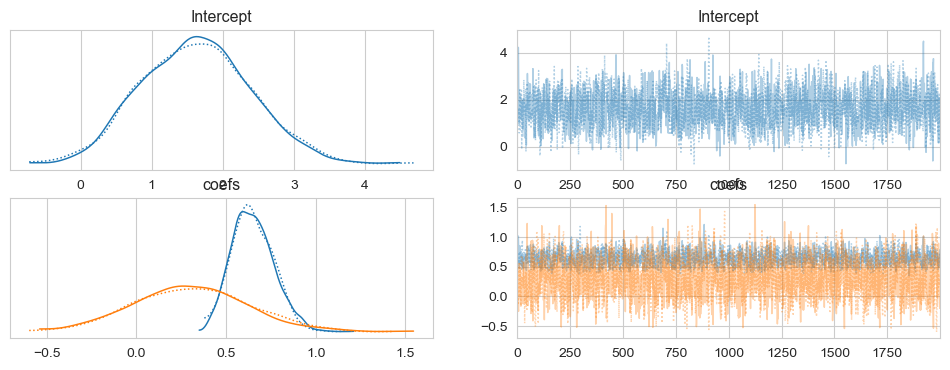

In [61]:
import arviz as az

# Save the summary table
summary = az.summary(trace)
summary.to_csv('model_summary.csv')  # Save as CSV if you want the table

# Save the trace plots
fig = az.plot_trace(trace)

summary



Top Left: Displays a bell-shaped posterior distribution centered between 1 and 2, reflecting the model's estimated baseline log-odds. This suggests that, on average, the log-odds of the target variable (divorce or married) fall within this range under the current model assumptions. The width  of the distribution indicates relatively high certainty about the estimate, with most of the posterior mass concentrated around this central value.

Top Right: It illustrates the sampling chain valuacross iterationsons. The mixing pattern is favorable, with the chain consistently exploring around the mean, suggesting strong converge and good MCMC mixing for the 5000 simulated draws of the intercept. Tnce. The lnds or drift indicates that the Markov chain has adequately explored the parameter space and that the sampling process has reached equilibrium. This indicates the reliability of the posterior estimates derived from the model.

Bottom Left: Shows two distinct posterior distributions in which a sharp blue peak around 0.6-0.7 suggests a strong, well-defined effect for one coefficient, However the broader orange distribution centered near 0 suggests more uncertainty about the other coefficient.

The 95% highest posterior density interval represents the likely range of the model parameters. When explaining the model parameters, we can present the mean as the "most likely" point estimate. However, the 95% credible interval highlights the uncertainty inherent in the model, reflecting the uncertainty that exists in when approximating real-world scenario in simple models. 

The convergence appears solid, with stable traces and no noticeable trends or stagnation. The Markov chains mix effectively, exploring the parameter space. The posterior distributions are aslo clear and unimodal and the model has identified at least one strong predictor, as seen by the distinct peak in the coefficient estimates.



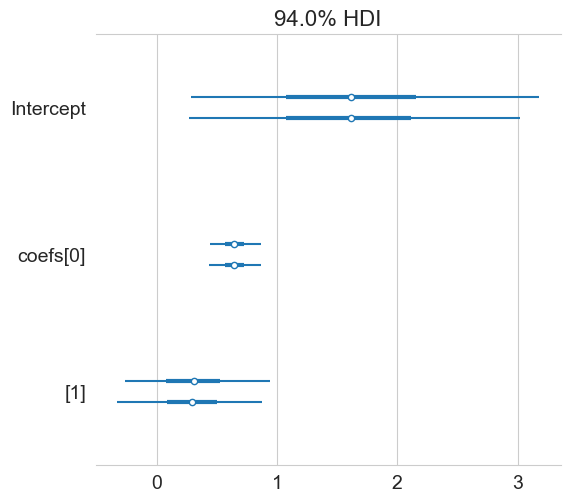

In [19]:
from IPython.core.pylabtools import figsize
figsize(10, 12)
pm.plot_forest(trace);

This is another way to plot the distribution of the sampled variables with the 94% highest posterior density. The model returns uncertainty measures for the coefficients. The model is less sure about the intercept than the other measures. 

## Convergence Diagnostics and Posterior Analysis

In [65]:
# Save the summary to different formats
summary = pm.summary(trace)

# Save as CSV (easy to import into PowerPoint as a table)
summary 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.626,0.765,0.347,3.183,0.020,0.014,1520.0,2372.0,1.0
coefs[0],0.649,0.117,0.433,0.862,0.003,0.002,1541.0,2002.0,1.0
coefs[1],0.306,0.323,-0.331,0.881,0.007,0.006,1937.0,2017.0,1.0


As can be seen in the summary table, all the parameters have R hat less than l.05 but close to 1 indicating good convergence
The R hat statistic assesses the convergence of Markov Chain Monte Carlo (MCMC) sampling. A value greater than 1.01 suggests that the chains may not have mixed well, and the posterior estimates could be unreliable. This shows our use of NUTS sampler was correct in relation to using the Metropolis sampler which may have struggled to sample efficiently.

The effective sample size tells us how many independent samples are effectively available for analysis, and higher values are better for robust inference. In this case all of them are above 150 which is a good indication. 

ESS measures the number of independent samples obtained from the posterior. A low ESS (<100) indicates that the sampler produced many correlated samples, reducing the effective information content.
Why it happens:

Insufficient tuning or too few iterations.
High posterior correlation among parameters, often due to model structure or poor prior choices.

In [37]:
energy_plot = az.plot_energy(trace)
plt.savefig('energy_plot.png', dpi=300, bbox_inches='tight')
plt.close()


The next step in evaluating our model is to verify if the NUTS sampler performed as expected. One way to do this is by examining the energy plot, which helps assess whether the NUTS algorithm adequately explored the posterior distribution. If the exploration is insufficient, there is a risk of biased posterior estimates due to some regions of the posterior not being visited frequently enough.

The energy plot displays two density estimates: one represents the marginal energy distribution of the sampling process, while the other shows the energy transitions between successive steps. The main goal is that the two distributions appear similar which by looking at the energy plot looks reasonable, suggesting that the NUTS sampler likely performed well.

These metrics align with our assumptions that we could balance out the reduction in computational cost while maintaining sampling efficiency during the sampling process.


Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.95      0.97        20

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34



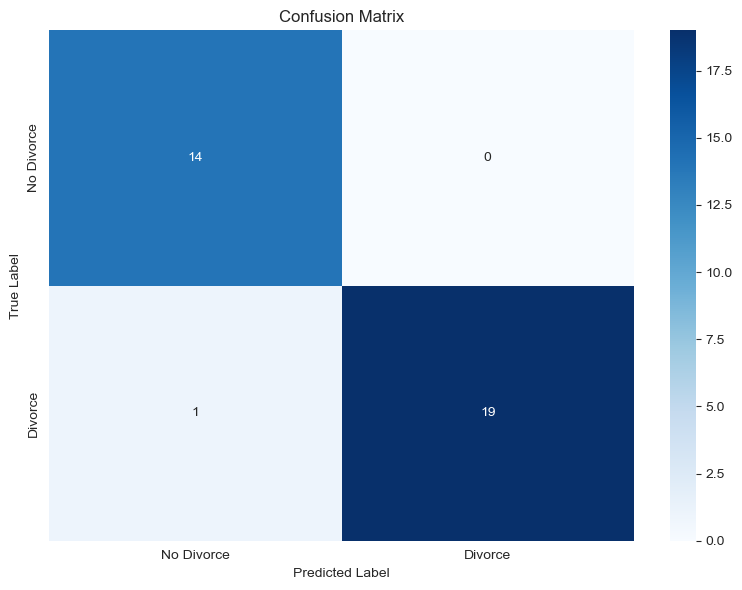

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_trace(trace):
    """
    Extracts mean and std of variables from the trace
    """
    means_dict = {}
    std_dict = {}
    
    # Extract intercept 
    means_dict['Intercept'] = float(np.mean(trace.posterior['Intercept']))
    std_dict['Intercept'] = float(np.std(trace.posterior['Intercept']))
    
    # Extract coefficients for each PC
    coefs_mean = np.mean(trace.posterior['coefs'], axis=(0,1))
    coefs_std = np.std(trace.posterior['coefs'], axis=(0,1))
    
    for i in range(len(coefs_mean)):
        means_dict[f'PC{i+1}'] = float(coefs_mean[i])
        std_dict[f'PC{i+1}'] = float(coefs_std[i])
    
    return means_dict, std_dict

def find_probs(trace, X_data):
    """
    Calculate probabilities using the mean values of the Bayesian model parameters
    """
    
    means_dict, _ = evaluate_trace(trace)
    
    
    X_with_intercept = np.column_stack([np.ones(len(X_data)), X_data])
    
    # Create coefficient array in correct order
    coef_names = ['Intercept'] + [f'PC{i+1}' for i in range(X_data.shape[1])]
    mean_array = np.array([means_dict[name] for name in coef_names])
    
    # Calculate logits and probabilities
    logits = np.dot(X_with_intercept, mean_array)
    probabilities = 1 / (1 + np.exp(-logits))
    
    return probabilities

def plot_confusion_matrix(cm, classes):
    """
    Plot confusion matrix with pretty formatting
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    return plt.gcf()

def calc_metrics(y_true, y_pred):
    """
    Calculate and print classification metrics
    """
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Split the PCA-transformed data into train and test sets
from sklearn.model_selection import train_test_split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Calculate probabilities using our trained model
probs = find_probs(trace, X_test_pca)

# Make predictions using 0.5 threshold
predictions = (probs > 0.5).astype(int)


calc_metrics(y_test, predictions)

# Create and plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes=['No Divorce', 'Divorce'])
plt.show()

In [27]:
# Save the confusion matrix
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes=['No Divorce', 'Divorce'])
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
# For higher quality:
plt.savefig('confusion_matrix.pdf', bbox_inches='tight')
plt.close()

# Results

## Confusion Matrix

Model Performance Analysis for Divorce Prediction

The classification results demonstrate exceptional predictive performance of our Bayesian logistic regression model, as evidenced by both the classification report and confusion matrix. Although the strength of Bayesian models is not in their accuracy but in interpretability.


Overall Model Performance:
 Accuracy: 0.97 (97%) - indicating exceptional overall prediction accuracy
 
Confusion Matrix Interpretation:
True Negatives (Top Left): 14 cases correctly predicted as no divorce.
False Positives (Top Right): 0 cases incorrectly predicted as divorce.
False Negatives (Bottom Left): 1 case incorrectly predicted as no divorce.
True Positives (Bottom Right): 19 cases correctly predicted as divorce.

These results indicate nearly perfect classification with only one misclassification out of 34 total cases. The single error was a false negative, where one divorce case was incorrectly classified as no divorce. This suggests that the model is slightly more conservative in predicting divorce.

The very high accuracy could be driven by overfitting, however, after looking through the literature on the dataset it aligns with other studies that get similar results where the dataset is almost perfectly balanced and models are able to capture the relationship between the predictors and outcome easily.

The balanced performance across both classes, despite the slight class imbalance (14 vs 20 cases), demonstrates that the model has effectively learned the underlying patterns without being biased toward either outcome. This robust performance validates both our feature engineering approach using PCA and the effectiveness of the Bayesian logistic regression implementation.

C:\Users\jamak\AppData\Local\Temp\ipykernel_19536\2181713966.py:54: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, grid_probs.reshape(xx.shape), levels=[0.5],


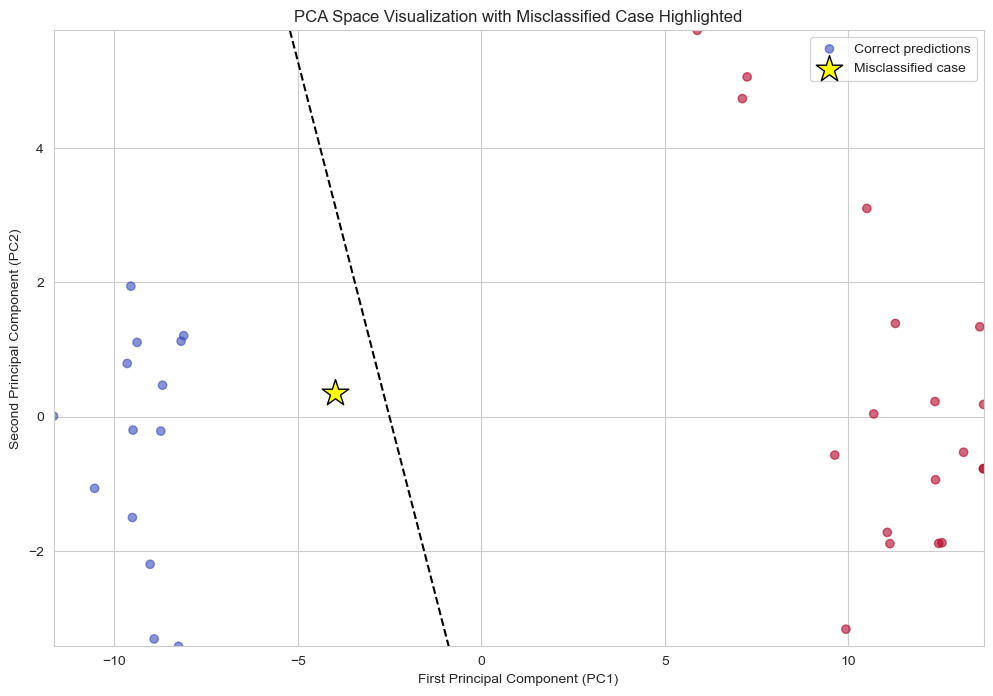

Analysis of Misclassified Case:
True Label: Divorce
Predicted Label: No Divorce
Predicted Probability: 0.298

Comparison with 5 Nearest Correctly Classified Cases:
Distance | True Label | Predicted Probability
---------------------------------------------
   4.205 | No Divorce | 0.037
   4.258 | No Divorce | 0.034
   4.697 | No Divorce | 0.020
   4.776 | No Divorce | 0.016
   5.441 | No Divorce | 0.016


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


test_probs = find_probs(trace, X_test_pca)
test_predictions = (test_probs > 0.5).astype(int)

# Find the misclassified case
misclassified_idx = np.where(test_predictions != y_test)[0]
correct_idx = np.where(test_predictions == y_test)[0]

# Get original features for the misclassified case
misclassified_pca = X_test_pca[misclassified_idx]
misclassified_prob = test_probs[misclassified_idx]
true_label = y_test.iloc[misclassified_idx].values[0]
predicted_label = test_predictions[misclassified_idx][0]




plt.figure(figsize=(12, 8))

# Plot correctly classified points
plt.scatter(X_test_pca[correct_idx, 0], X_test_pca[correct_idx, 1],
           c=y_test.iloc[correct_idx], cmap='coolwarm', alpha=0.6,
           label='Correct predictions')

# Plot misclassified point with a different marker
plt.scatter(misclassified_pca[0, 0], misclassified_pca[0, 1],
           color='yellow', marker='*', s=400, edgecolor='black',
           label='Misclassified case')

plt.xlabel('First Principal Component (PC1)')
plt.ylabel('Second Principal Component (PC2)')
plt.title('PCA Space Visualization with Misclassified Case Highlighted')
plt.legend()

# Add decision boundary
grid_x = np.linspace(X_test_pca[:, 0].min(), X_test_pca[:, 0].max(), 100)
grid_y = np.linspace(X_test_pca[:, 1].min(), X_test_pca[:, 1].max(), 100)
xx, yy = np.meshgrid(grid_x, grid_y)
grid = np.c_[xx.ravel(), yy.ravel()]

# Get probabilities for grid
grid_with_intercept = np.column_stack([np.ones(len(grid)), grid])
means_dict, _ = evaluate_trace(trace)
coef_names = ['Intercept'] + [f'PC{i+1}' for i in range(2)]
mean_array = np.array([means_dict[name] for name in coef_names])
grid_probs = 1 / (1 + np.exp(-np.dot(grid_with_intercept, mean_array)))

# Plot decision boundary
plt.contour(xx, yy, grid_probs.reshape(xx.shape), levels=[0.5],
            colors='k', linestyles='--', label='Decision Boundary')
plt.savefig('pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare with nearby correctly classified cases
# Calculate distances to all other points
distances = np.sqrt(np.sum((X_test_pca - misclassified_pca)**2, axis=1))
nearest_correct_idx = np.argsort(distances)[1:6]  # 5 neearest neighbors


print("Analysis of Misclassified Case:")
print(f"True Label: {'Divorce' if true_label == 1 else 'No Divorce'}")
print(f"Predicted Label: {'Divorce' if predicted_label == 1 else 'No Divorce'}")
print(f"Predicted Probability: {misclassified_prob[0]:.3f}")
print("\nComparison with 5 Nearest Correctly Classified Cases:")
print("Distance | True Label | Predicted Probability")
print("-" * 45)
for idx in nearest_correct_idx:
    dist = distances[idx]
    label = y_test.iloc[idx]
    prob = test_probs[idx]
    print(f"{dist:8.3f} | {'Divorce' if label == 1 else 'No Divorce':10} | {prob:.3f}")

KeyError: 'PC1'

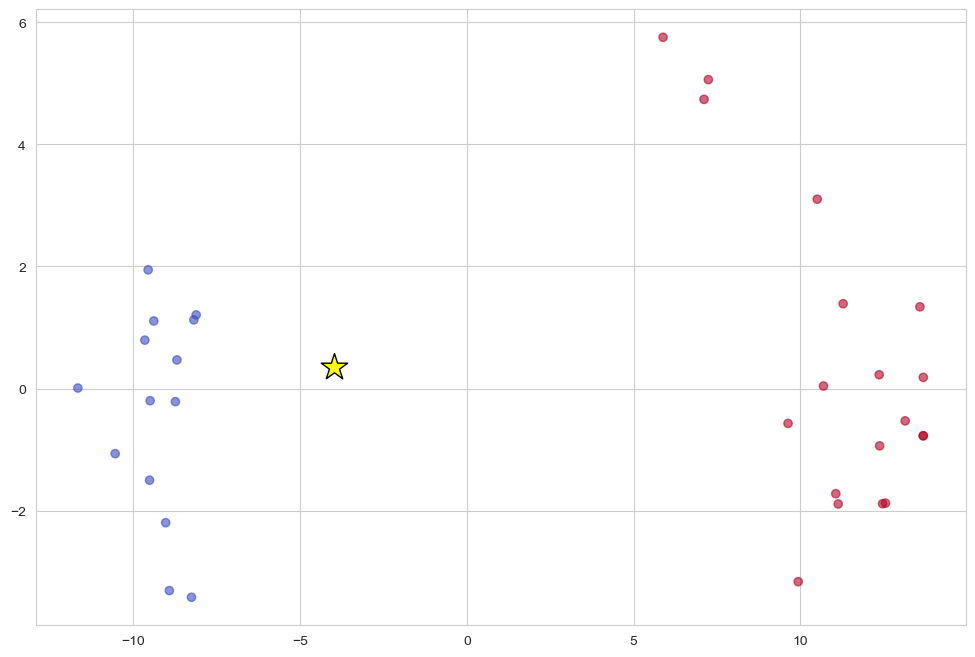

In [45]:
# Create the PCA visualization
plt.figure(figsize=(12, 8))

# Plot correctly classified points
plt.scatter(X_test_pca[correct_idx, 0], X_test_pca[correct_idx, 1],
           c=y_test.iloc[correct_idx], cmap='coolwarm', alpha=0.6,
           label='Correct predictions')

# Plot misclassified point
plt.scatter(misclassified_pca[0, 0], misclassified_pca[0, 1],
           color='yellow', marker='*', s=400, edgecolor='black',
           label='Misclassified case')

# Add decision boundary
grid_x = np.linspace(X_test_pca[:, 0].min(), X_test_pca[:, 0].max(), 100)
grid_y = np.linspace(X_test_pca[:, 1].min(), X_test_pca[:, 1].max(), 100)
xx, yy = np.meshgrid(grid_x, grid_y)
grid = np.c_[xx.ravel(), yy.ravel()]

grid_with_intercept = np.column_stack([np.ones(len(grid)), grid])
means_dict = pm.summary(trace)['mean']  # This is the corrected line
coef_names = ['Intercept'] + [f'PC{i+1}' for i in range(2)]
mean_array = np.array([means_dict[name] for name in coef_names])
grid_probs = 1 / (1 + np.exp(-np.dot(grid_with_intercept, mean_array)))

plt.contour(xx, yy, grid_probs.reshape(xx.shape), levels=[0.5],
            colors='k', linestyles='--', label='Decision Boundary')

plt.xlabel('First Principal Component (PC1)')
plt.ylabel('Second Principal Component (PC2)') 
plt.title('PCA Space Visualization with Misclassified Case Highlighted')
plt.legend()

# Save with high resolution
plt.savefig('pca_misclassified.png', dpi=300, bbox_inches='tight')
plt.close()

Looking further into the miscalssification results we can see the one misclassified case (yellow star) reveals a false negative. The true label for the case is "Divorce," but the model predicted "No Divorce," assigning only a 30% probability of divorce. This indicates that the model failed to correctly identify a genuine divorce case given that our threshold is 0.5. 

All five of the closest cases in feature space were correctly classified as "No Divorce," with very low probabilities of divorce ranging from 1.6% to 3.7%. The distances between the misclassified case and its nearest neighbors range from 4.2 to 5.4.

This indicates that the misclassification shared similar characteristics with the non divorced/ married people but were divorced which may indicative of an outlier. 

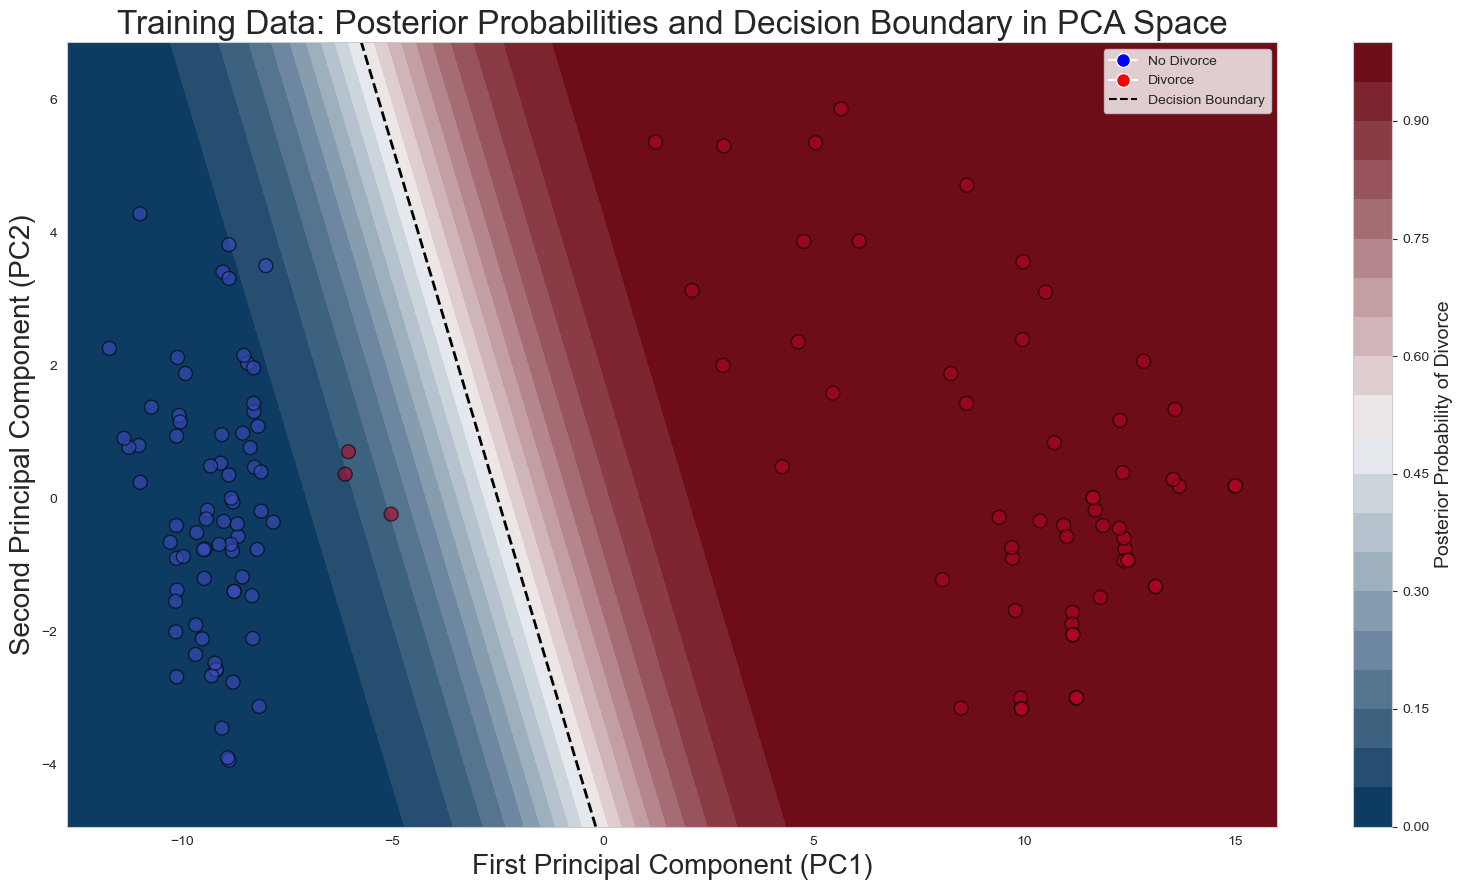

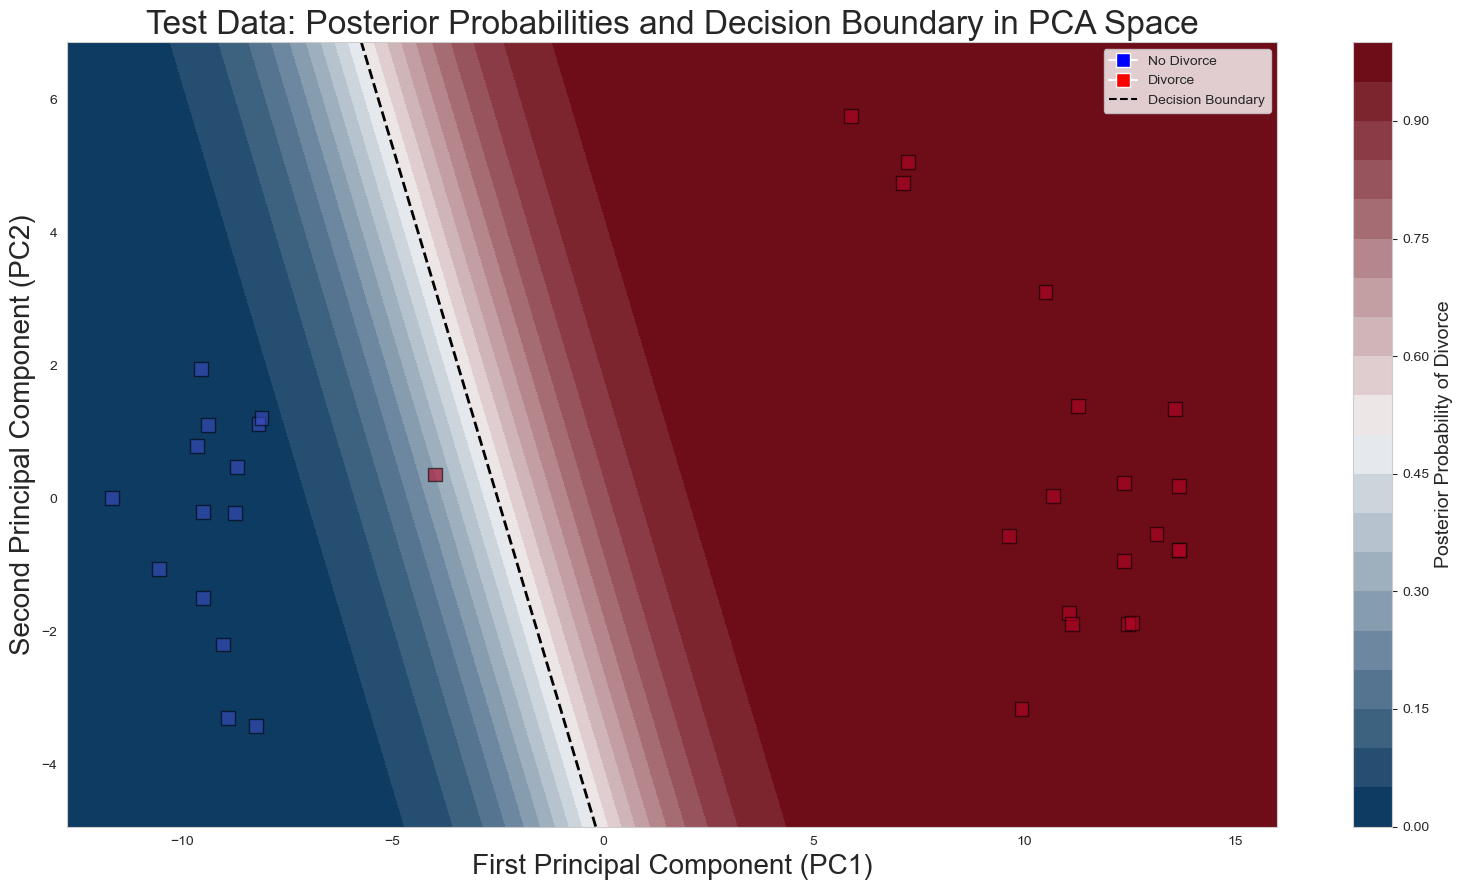

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

from sklearn.model_selection import train_test_split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Create function to plot the data
def plot_pca_results(X_pca, y, grid, probs, title, is_test=False):
    plt.figure(figsize=(16, 9))
    
    
    cmap = sns.diverging_palette(250, 10, s=99, l=20, as_cmap=True)
    
    # Create contour plot of probabilities
    contour = plt.contourf(grid[0].reshape(1000, 1000),
                          grid[1].reshape(1000, 1000),
                          probs.reshape(1000, 1000),
                          levels=np.linspace(0, 1, 21),
                          cmap=cmap)
    
    # Add decision boundary (where probability = 0.5)
    plt.contour(grid[0].reshape(1000, 1000),
                grid[1].reshape(1000, 1000),
                probs.reshape(1000, 1000),
                levels=[0.5],
                colors='k',
                linewidths=2,
                linestyles='dashed')
    
    # Plot the data points
    marker = 's' if is_test else 'o'
    plt.scatter(X_pca[:, 0], X_pca[:, 1],
               c=y,
               cmap='coolwarm',
               s=100,
               alpha=0.6,
               edgecolor='black',
               marker=marker)
    
   
    cbar = plt.colorbar(contour)
    cbar.ax.set_ylabel('Posterior Probability of Divorce', size=14)
    
   
    plt.xlabel('First Principal Component (PC1)', size=20)
    plt.ylabel('Second Principal Component (PC2)', size=20)
    plt.title(title, size=24)
    
    
    legend_elements = [
        plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='blue',
                   markersize=10, label='No Divorce'),
        plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='red',
                   markersize=10, label='Divorce'),
        plt.Line2D([0], [0], color='k', linestyle='--',
                   label='Decision Boundary')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()

# Create grid for contour plot using combined ranges
xs = np.linspace(min(X_train_pca[:, 0].min(), X_test_pca[:, 0].min()) - 1,
                 max(X_train_pca[:, 0].max(), X_test_pca[:, 0].max()) + 1,
                 1000)
ys = np.linspace(min(X_train_pca[:, 1].min(), X_test_pca[:, 1].min()) - 1,
                 max(X_train_pca[:, 1].max(), X_test_pca[:, 1].max()) + 1,
                 1000)

# Create grid for contour plot
grid = pm.floatX(np.mgrid[xs.min():xs.max():1000j,
                         ys.min():ys.max():1000j])
grid_2d = grid.reshape(2, -1).T

# Get means of model parameters
means_dict = evaluate_trace(trace)[0]  
coef_names = ['Intercept'] + [f'PC{i+1}' for i in range(2)]
mean_array = np.array([means_dict[name] for name in coef_names])

# Calculate logits and probabilities for grid points
grid_with_intercept = np.column_stack([np.ones(len(grid_2d)), grid_2d])
logits = np.dot(grid_with_intercept, mean_array)
probs = 1 / (1 + np.exp(-logits))

# Create training data plot
plot_pca_results(X_train_pca, y_train, grid, probs, 
                 'Training Data: Posterior Probabilities and Decision Boundary in PCA Space')

# Create test data plot
plot_pca_results(X_test_pca, y_test, grid, probs, 
                 'Test Data: Posterior Probabilities and Decision Boundary in PCA Space',
                 is_test=True)




plt.show()

We will use colour to represent our predicted probability. We can make predictions for a grid of xs and ys points and then colour the background of the plot based on the probabilities. This will provide us with another opportunity to see how choosing a different threshold may be more appropriate depending on our objectives and the weight we place on the false negatives / false positives balance.

Key elements in both graphs include a dashed black decision boundary representing the 0.5 probability threshold (separating predicted divorce from married), a color gradient transitioning from dark blue (low divorce probability) to dark red (high divorce probability), and data points—circles for training data and squares for test data—plotted with the first principal component (PC1) on the x-axis and the second principal component (PC2) on the y-axis.

In the training data graph, there is a clear separation between divorce (red) and no-divorce (blue) cases, indicating that the model has learned meaningful patterns. No-divorce cases cluster on the left side, primarily between -2 and 0 on PC1, while divorce cases cluster on the right with higher PC1 values. The decision boundary effectively separates the two classes, with only a few misclassifications near the boundary. The smooth color gradient from blue to red demonstrates the model's confidence, with darker colors at the extremes indicating high certainty far from the decision boundary.

The test data graph shows a similar pattern to the training data, reflecting good generalization. Although the test set has fewer points , the clustering patterns and decision boundary remain consistent. Most test cases fall confidently within their respective regions (dark blue or dark red), with only a few borderline cases near the boundary.

Overall, the model demonstrates strong generalization, effective feature extraction through PCA, and a reliable decision boundary. The smooth probability gradient further provides a clear and interpretable measure of the model’s confidence in its predictions across different regions of the feature space.

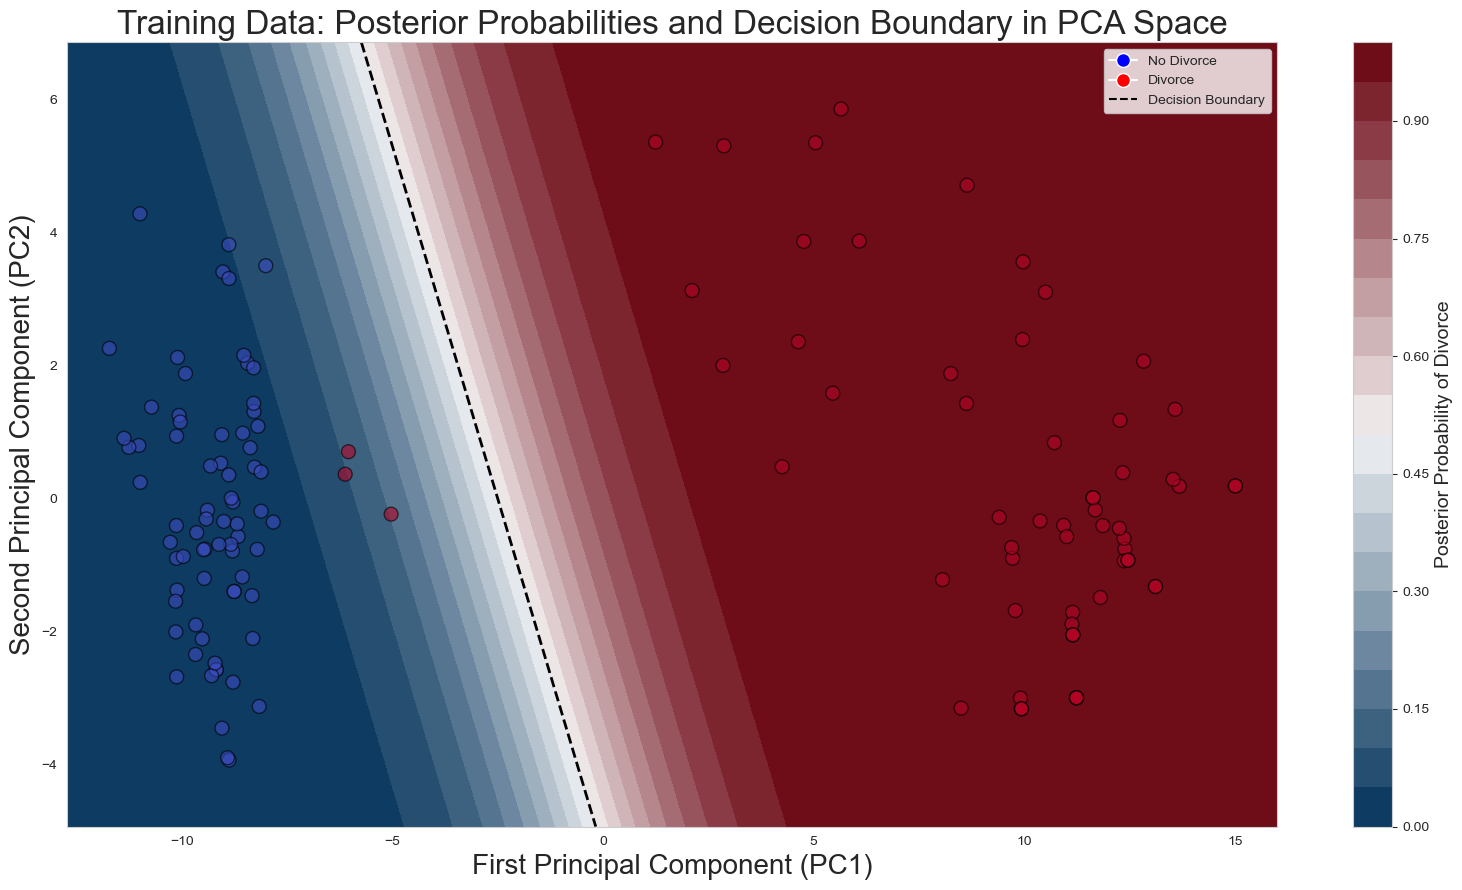

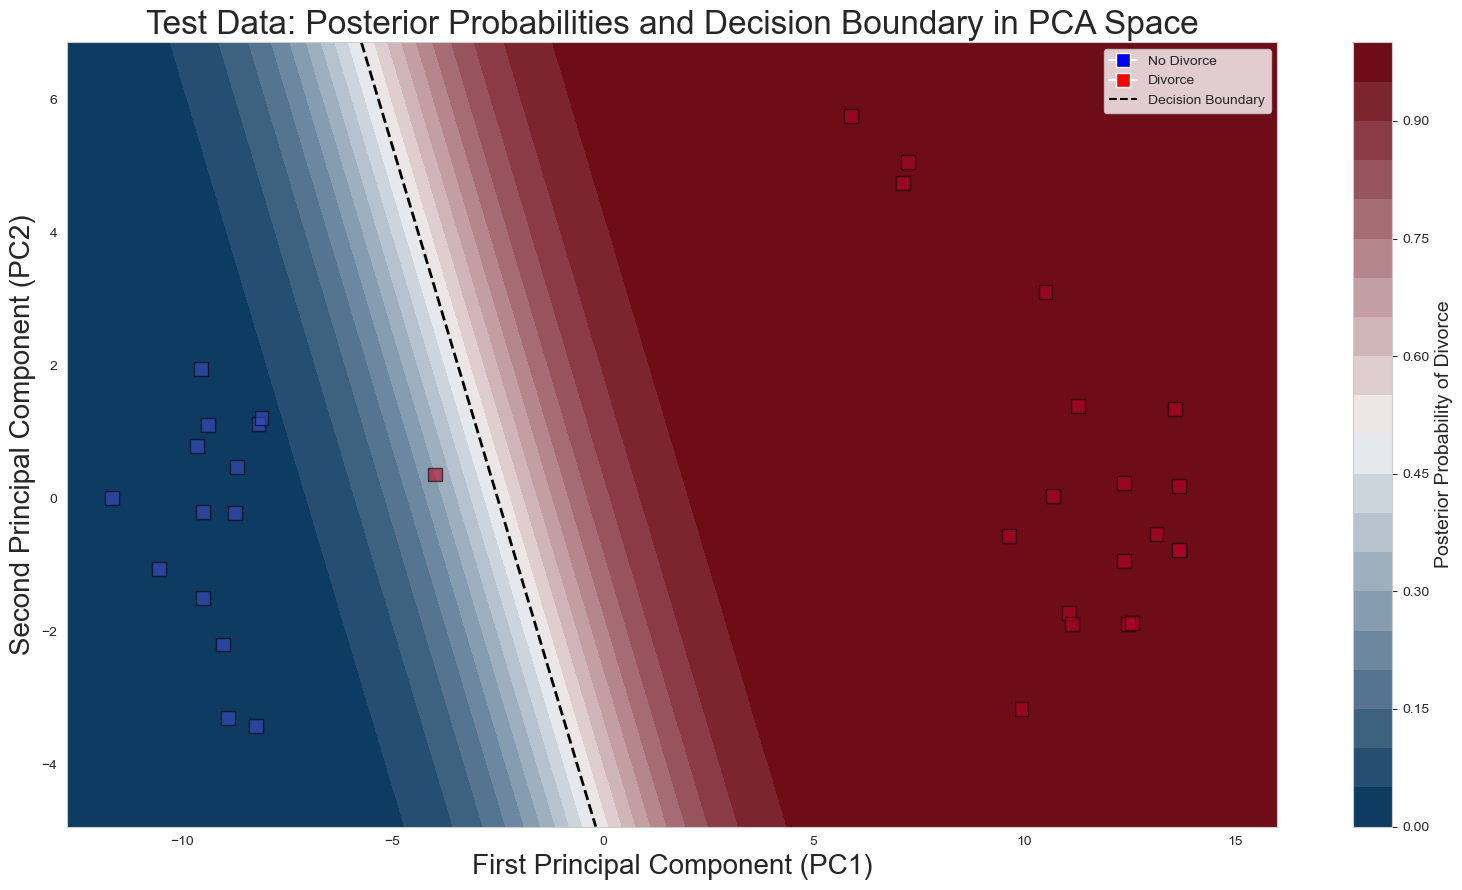

In [57]:
def plot_pca_results(X_pca, y, grid, probs, title, is_test=False):
    fig = plt.figure(figsize=(16, 9))
    
    cmap = sns.diverging_palette(250, 10, s=99, l=20, as_cmap=True)
    
    # Reshape grid correctly
    xx = grid[0]  # First component grid
    yy = grid[1]  # Second component grid
    
    # Create contour plot of probabilities
    contour = plt.contourf(xx, yy, probs.reshape(xx.shape),
                          levels=np.linspace(0, 1, 21),
                          cmap=cmap)
    
    # Add decision boundary (where probability = 0.5)
    plt.contour(xx, yy, probs.reshape(xx.shape),
                levels=[0.5],
                colors='k',
                linewidths=2,
                linestyles='dashed')
    
    # Plot the data points
    marker = 's' if is_test else 'o'
    plt.scatter(X_pca[:, 0], X_pca[:, 1],
               c=y,
               cmap='coolwarm',
               s=100,
               alpha=0.6,
               edgecolor='black',
               marker=marker)
    
    cbar = plt.colorbar(contour)
    cbar.ax.set_ylabel('Posterior Probability of Divorce', size=14)
    
    plt.xlabel('First Principal Component (PC1)', size=20)
    plt.ylabel('Second Principal Component (PC2)', size=20)
    plt.title(title, size=24)
    
    legend_elements = [
        plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='blue',
                   markersize=10, label='No Divorce'),
        plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='red',
                   markersize=10, label='Divorce'),
        plt.Line2D([0], [0], color='k', linestyle='--',
                   label='Decision Boundary')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    return fig

# Create grid for contour plot using combined ranges
xs = np.linspace(min(X_train_pca[:, 0].min(), X_test_pca[:, 0].min()) - 1,
                 max(X_train_pca[:, 0].max(), X_test_pca[:, 0].max()) + 1,
                 100)  # Changed from 1000 to 100 for better performance
ys = np.linspace(min(X_train_pca[:, 1].min(), X_test_pca[:, 1].min()) - 1,
                 max(X_train_pca[:, 1].max(), X_test_pca[:, 1].max()) + 1,
                 100)  # Changed from 1000 to 100 for better performance

# Create meshgrid
xx, yy = np.meshgrid(xs, ys)
grid = np.array([xx, yy])
grid_2d = np.column_stack([xx.ravel(), yy.ravel()])

# Get means of model parameters
means_dict = evaluate_trace(trace)[0]  
coef_names = ['Intercept'] + [f'PC{i+1}' for i in range(2)]
mean_array = np.array([means_dict[name] for name in coef_names])

# Calculate logits and probabilities for grid points
grid_with_intercept = np.column_stack([np.ones(len(grid_2d)), grid_2d])
logits = np.dot(grid_with_intercept, mean_array)
probs = 1 / (1 + np.exp(-logits))

# Create and save training data plot
train_fig = plot_pca_results(X_train_pca, y_train, grid, probs, 
                 'Training Data: Posterior Probabilities and Decision Boundary in PCA Space')
train_fig.savefig('training_pca_visualization.png', dpi=300, bbox_inches='tight')

# Create and save test data plot
test_fig = plot_pca_results(X_test_pca, y_test, grid, probs, 
                 'Test Data: Posterior Probabilities and Decision Boundary in PCA Space',
                 is_test=True)
test_fig.savefig('test_pca_visualization.png', dpi=300, bbox_inches='tight')

plt.show()

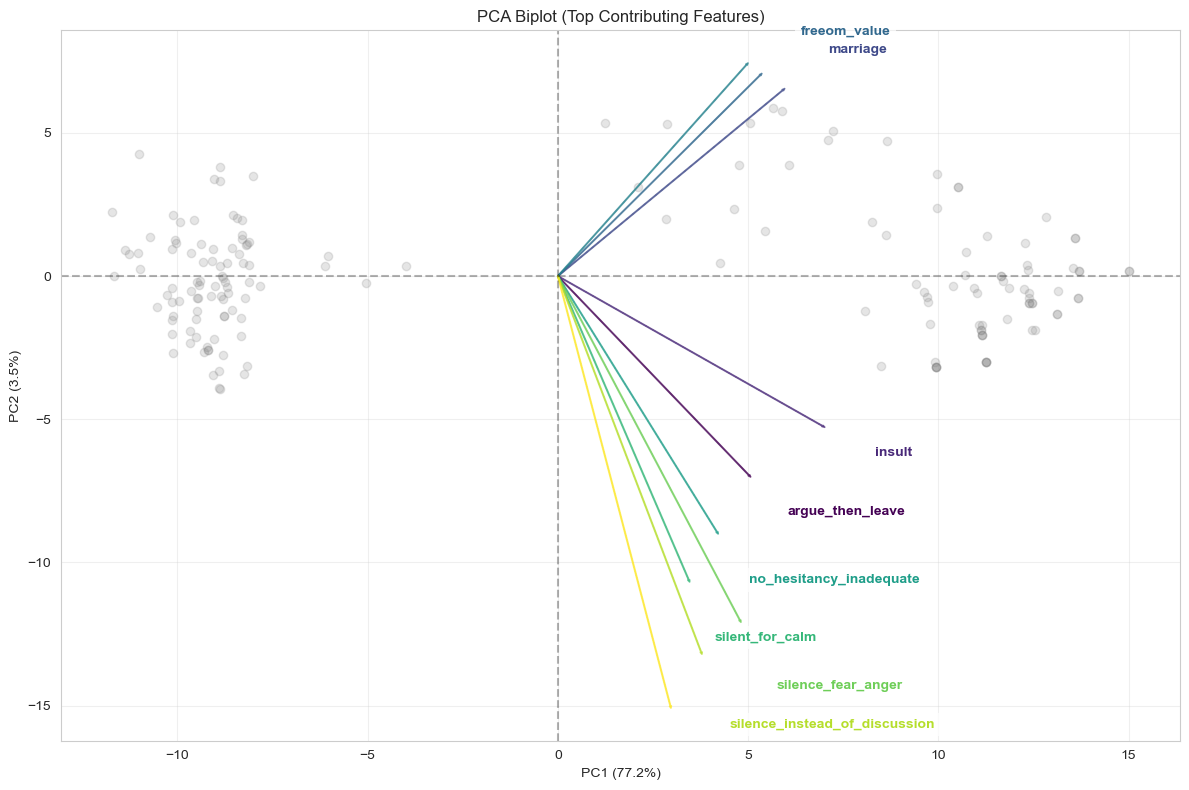

In [59]:
def create_focused_biplot(pca, X, features, n_top_features=10, components=[0, 1], figsize=(12, 8)):
    """
    Create a biplot focusing on top contributing features.
    
    """
    scores = pca.transform(X)
    loadings = pca.components_
    
    # Get the most important features for these components
    loading_coords = loadings[components, :]
    feature_importance = np.sum(loading_coords**2, axis=0)
    top_features_idx = np.argsort(feature_importance)[-n_top_features:]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot scores with alpha based on density
    score_coords = scores[:, components]
    plt.scatter(score_coords[:, 0], score_coords[:, 1], alpha=0.2, color='gray')
    
    
    scale_factor = np.abs(score_coords).max() / np.abs(loading_coords[:, top_features_idx]).max()
    
    # Create color map for arrows based on importance
    importance_colors = plt.cm.viridis(np.linspace(0, 1, len(top_features_idx)))
    
    for idx, (feature_idx, color) in enumerate(zip(top_features_idx, importance_colors)):
        plt.arrow(0, 0,
                 loading_coords[0, feature_idx] * scale_factor,
                 loading_coords[1, feature_idx] * scale_factor,
                 color=color, alpha=0.7, width=0.02)
        
        # Adjust text position to avoid overlap
        angle = np.arctan2(loading_coords[1, feature_idx], loading_coords[0, feature_idx])
        text_distance = scale_factor * 1.2
        text_x = loading_coords[0, feature_idx] * text_distance
        text_y = loading_coords[1, feature_idx] * text_distance
        
        plt.annotate(features[feature_idx], 
                    (text_x, text_y),
                    color=color,
                    fontweight='bold',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    plt.xlabel(f'PC{components[0]+1} ({pca.explained_variance_ratio_[components[0]]:.1%})')
    plt.ylabel(f'PC{components[1]+1} ({pca.explained_variance_ratio_[components[1]]:.1%})')
    plt.title('PCA Biplot (Top Contributing Features)')
    
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pca_biplot.png', dpi=300, bbox_inches='tight')
    plt.show()


create_focused_biplot(pca, X, X.columns.tolist(), n_top_features=10)

This PCA biplot presents a visualization of divorce prediction patterns through Bayesian logistic regression, showing relationship dynamics and their connection to divorce probability. The analysis shows two principal components, with PC1 explaining a remarkable 77.2% of the variance and PC2 accounting for 3.5%, collectively capturing over 80% of the data's variability.

In the upper quadrant, we find positive relationship indicators like "freedom_value" and "marriage" clustering together, suggesting these represent constructive aspects of relationship health. Their positive correlation indicates they tend to appear together in stable relationships.

Conversely, the lower portion of the plot reveals a detailed progression of negative relationship patterns. These break down into two main categories: active conflict and passive withdrawal. The active conflict variables include "insult" and "argue_then_leave," while the passive withdrawal cluster encompasses multiple silence-related variables: "silence_instead_of_discussion," "silence_fear_anger," and "silent_for_calm." This aligns with the literature that Conflict resolution strategies in relationships have a large effect on divorces. This is further proven by other forms of conflict resolution that may not be effective in relationships such as silence clustering together. Their close alignment suggests that different forms of communication withdrawal tend to co-occur in relationships, potentially indicating a broader pattern of communication breakdown. The length and direction of these vectors suggest they are particularly strong predictors of divorce probability, possibly even more so than active conflict behaviors.

The clear separation along PC1, which explains over three-quarters of the variance, indicates that these communication and behavioral patterns are highly effective predictors of relationship outcomes. The clustering of points suggests distinct patterns in how relationships manifest these behaviors, with some couples showing high levels of negative communication patterns and others demonstrating more positive interaction styles.

This visualization shows how constructive relationship behaviors and conflict-oriented behaviors tend to be mutually exclusive, with relationships generally characterized by one pattern or the other. The high percentage of variance explained by PC1 (77.2%) suggests that these behavioral patterns form a robust predictor of relationship outcomes, potentially offering valuable insights for early intervention in troubled relationships. The analysis particularly highlights how silence and communication breakdown, even more than overt conflict, may be the strongest indicators of relationship distress and potential divorce.

#  Discussion of Results: Bayesian Divorce Prediction Using Principal Component Analysis

The optimization of principal components yielded a remarkably efficient dimensionality reduction, with just two PCs providing optimal predictive power (minimum error rate of 0.0137). Our finding suggests that the complex dynamics of marital relationships, originally captured through the survey questions, can be effectively represented in a two-dimensional space. The sharp increase in cross-validation error beyond two PCs indicates that additional dimensions introduce noise rather than meaningful information, validating our parsimonious approach to feature selection.

The model's predictive performance is strong, achieving a 97% overall accuracy rate with balanced performance across both divorce and no-divorce predictions. The confusion matrix reveals near-perfect classification with only one misclassification out of 34 test cases. This single error was a false negative, suggesting a slightly conservative bias in divorce prediction. Though the accuracy may be high it aligns with most work done on this dataset.

The visualization of decision boundaries show clear separation between divorce and no-divorce cases in both training and test sets, coupled with smooth probability gradients, indicates that the model has captured genuine underlying patterns rather than overfitting to the training data. This is further supported by the consistent performance between training and test sets, as evidenced by the similar spatial distribution of points in both visualizations.

From a methodological perspective, the success of using just two principal components suggests the existence of fundamental factors underlying divorce prediction. This finding could have significant implications for understanding marital dynamics and could potentially inform more focused approaches to marriage counseling or early intervention strategies

## Limitations 

A limitation of our study is the relatively small sample size (34 test cases), though the model's robust performance and clear separation of classes suggest that the patterns identified are genuine rather than artifacts of limited data. Additionally, the high accuracy might indicate potential selection bias in the dataset or the possibility that the survey questions were particularly well-designed to capture divorce risk factors.This could be the case as the survey questions were developed based on Gottmans relationship research which explains why they are so accurate at pin-pointing risk factors.

These results demonstrate the potential of combining modern Bayesian methods with dimensionality reduction techniques in predicting complex social outcomes. The model's ability to achieve high accuracy while maintaining interpretability and providing uncertainty estimates makes it a valuable tool for both research and practical applications in marriage counseling and relationship assessment.

## Future Research 

Future research could focus on validating these findings with larger, more diverse datasets and investigating the specific relationship factors that contribute most strongly to the two principal components. Additionally, exploring the model's performance across different cultural contexts and relationship types could provide insights into the universality of the patterns identified. Longitudinal studies that track couples over extended periods would provide insights into how these predictions hold up as relationships evolve. Beyond improving temporal robustness, future work could expand the feature set to encompass dynamic data sources—such as social media activity, financial patterns, or political views—offering a more holistic perspective on marital dynamics.

# Conclusion 
Our study advances the methodological framework for divorce prediction by introducing a Bayesian logistic regression model enhanced by PCA, building upon previous machine learning approaches in the field. While prior research by Kon and Chai (2020) and Yontem et al. (2019) demonstrated the effectiveness of SVM and tree-based methods, our Bayesian approach offers unique advantages in uncertainty quantification and interpretability while maintaining comparable predictive performance.
The integration of PCA with Bayesian inference represents a novel contribution to the divorce prediction literature. Our model, implemented through PyMC3 with the No-U-Turn Sampler (NUTS), achieved robust prediction capabilities while providing fuller insights into parameter uncertainty. The choice of NUTS over traditional samplers like Metropolis-Hastings proved particularly valuable for handling the high-dimensional, correlated nature of relationship data, offering more efficient exploration of the parameter space and better handling of posterior distributions.
Our findings align with previous research in identifying negative conflict behaviors as crucial predictors and poor conflict resolution strategies as predictors of divorce. The PCA transformation revealed that communication breakdown patterns, particularly various forms of silence and withdrawal, are strongly predictive of divorce outcomes. This aligns with but also refines previous findings about the importance of communication patterns in marital stability. PCA facilitated a more interpretable linear decision boundary, suggesting that even a few strongly negative behaviors can sharply influence marital outcomes. By reducing complexity and focusing the model’s attention on core dimensions, this approach not only maintained competitive accuracy but also offered clearer insights into the factors that decisively distinguish one marital status from another.

This approach holds particular promise for clinical applications in couples therapy and early intervention strategies. These findings establish a foundation for future research incorporating diverse datasets and more complex Bayesian hierarchical models to capture cultural and contextual variations in relationship dynamics.